### 自适应控制参数改进 DE 算法（SACPMDE）

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

def sacpmde(fobj, bounds, popsize=20, its=1000, goal = 0):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    pop_denorm = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in pop_denorm])
    best_idx = np.argmin(fitness)
    best = pop_denorm[best_idx]
    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            select_idx = (np.random.choice(idxs, 3, replace = False)).tolist()
            fit_select = [fitness[i1] for i1 in select_idx]
            best1 = np.argmin(fit_select)
            others = [n for n in range(len(select_idx)) if n != best1]
            a = pop[select_idx[best1]]
            b = pop[select_idx[others[0]]]
            c = pop[select_idx[others[1]]]
            mut = 0.1 + (0.9 - 0.1)*((fitness[select_idx[others[0]]] - fitness[select_idx[best1]]) / (fitness[select_idx[others[1]]] - fitness[select_idx[best1]]))
            mutant = np.clip(a + mut * (b - c), 0, 1)
            crossp = 0.1
            if(fitness[j] > np.mean(fitness)):
                crossp = 0.1 + (0.6 - 0.1)*(fitness[j] - min(fitness) / (max(fitness) - min(fitness)))
            cross_points = np.random.rand(dimensions) < crossp
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])
            trial_denorm = min_b + trial * diff
            f = fobj(trial_denorm)
            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial_denorm
        if(np.fabs(min(fitness) - goal) < 1e-6):
            break 
        yield best, fitness[best_idx]


### 基本DE 参数采用固定值 rand/1/bin

In [10]:
def de(fobj, bounds, mut=0.8, crossp=0.7, popsize=20, its=1000, goal = 0):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    pop_denorm = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in pop_denorm])
    best_idx = np.argmin(fitness)
    best = pop_denorm[best_idx]
    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace = False)]
            mutant = np.clip(a + mut * (b - c), 0, 1)
            cross_points = np.random.rand(dimensions) < crossp
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])
            trial_denorm = min_b + trial * diff
            f = fobj(trial_denorm)
            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial_denorm  
        if(np.fabs(min(fitness) - goal) < 1e-6):
            break
        yield best, fitness[best_idx]

### 非线性变化参数的DE

In [33]:
import numpy as np
def de1(fobj, bounds, mut=0.8, crossp=0.7, popsize=20, its=1000, goal = 0):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    pop_denorm = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in pop_denorm])
    best_idx = np.argmin(fitness)
    best = pop_denorm[best_idx]
    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace = False)]
            t = np.exp(1-(its/(its + 1 - i)))
            mut = 0.5 * (2 ** t)
            mutant = np.clip(a + mut * (b - c), 0, 1)
            cross_points = np.random.rand(dimensions) < crossp
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])
            trial_denorm = min_b + trial * diff
            f = fobj(trial_denorm)
            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial_denorm  
        if(np.fabs(min(fitness) - goal) < 1e-6):
            break
        yield best, fitness[best_idx]

### 几个待优化函数

$$Ackley:\quad f(x)=20+exp(1)+20exp(-0.2\sqrt{\frac 12 \sum_{i=1}^2 x_i^2} - exp(\frac 12 \sum_{i=1}^2cos(2 \pi x_i))\quad -32.768\le x_i \le 32.768$$

$$Rastrigin:\quad f(x)=\frac{(\sin^2\sqrt{x_1^2+x_2^2}-0.5)}{(1+0.001(x_1^2+x_2^2))^2}-0.5\quad-100\le x_1,x_2 \le100$$

$$Schaffer:\quad f(x)=\sum_1^{30}(x_i^2-10cos(2\pi x_i)+10)\quad -5.12\le x_i \le 5.12$$

$$Griewank:\quad f(x)=\frac 1{4000}\sum_{i=1}^{30}x_i^2-\prod_{i=1}^n cos{\left(\frac {x_i}{\sqrt i}\right)}+1\quad -60\le {x_i}\le 60$$

In [12]:
# Ackley 函数，二维
def Ackley(x):
    p1 = -0.2 * ((0.5 * sum(x ** 2))** 0.5)
    p2 = 0.5 * (sum(np.cos(2 * np.pi * x)))
    return np.exp(1) + 20 - 20 * np.exp(p1) - np.exp(p2)

# Rastrigin 函数维数不定
def Rastrigin(x):
    return sum(x ** 2 - 10 * np.cos(2 * np.pi * x) + 10)

# Schaffer 函数变体，因为原函数是求最大值。此变体的最小值是-1, 对应x为(0,0)
def Schaffer(x):
    return ((np.sin(sum(x ** 2)** 0.5))** 2 - 0.5)/((1 + 0.001 * (sum(x ** 2)))** 2) - 0.5

# Griewank函数
def Griewank(x):
    part = 1
    for i in range (len(x)):
        part *= np.cos(x[i]/(i+1) ** 0.5)
    return 1 - part + sum(x ** 2) / 4000

### 对几个函数的优化情况测试方法

In [50]:
def Ackley_sacpmde():
    start = datetime.datetime.now()
    it = list(sacpmde(Ackley, [(-32.768,32.768)] * 2, popsize = 20, its = 50))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='Ackley with adaptive parameters')
    plt.yscale('log')
    plt.legend()
    plt.savefig('Ackley with adaptive parameters')
    end = datetime.datetime.now()
    print(end - start)

def Ackley_de():
    start = datetime.datetime.now()
    it = list(de(Ackley, [(-32.768,32.768)] * 2, mut = 0.5, crossp = 0.5, popsize = 20, its = 50))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='Ackley with f = 0.5, cr = 0.5, np = 20')
    plt.yscale('log')
    plt.legend()
    plt.savefig('Ackley with de')
    end = datetime.datetime.now()
    print(end - start)
    
def Ackley_de1():
    start = datetime.datetime.now()
    it = list(de1(Ackley, [(-32.768,32.768)] * 2, crossp = 0.25, popsize = 20, its = 50))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='Ackley with de1')
    plt.yscale('log')
    plt.legend()
    plt.savefig('Ackley with de1')
    end = datetime.datetime.now()
    print(end - start)
    
def Schaffer_sacpmde():
    start = datetime.datetime.now()
    it = list(sacpmde(Schaffer, [(-100,100)] * 2, popsize = 40, its = 200, goal = -1))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='Schaffer with adaptive parameters')
    plt.legend()
    plt.savefig('Schaffer with adaptive parameters')
    end = datetime.datetime.now()
    print(end - start)
    
def Schaffer_de():
    start = datetime.datetime.now()
    it = list(de(Schaffer, [(-100,100)] * 2, mut = 0.5, crossp = 0.5, popsize = 40, its = 200, goal = -1))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='Schaffer with f = 0.5, cr = 0.5, np = 40')
    plt.legend()
    plt.savefig('Schaffer with de')
    end = datetime.datetime.now()
    print(end - start)
    
def Schaffer_de1():
    start = datetime.datetime.now()
    it = list(de1(Schaffer, [(-100,100)] * 2, crossp = 0.5, popsize = 40, its = 200, goal = -1))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='Schaffer with de1')
    plt.legend()
    plt.savefig('Schaffer with de1')
    end = datetime.datetime.now()
    print(end - start)
    
def Rastrigin_sacpmde():
    start = datetime.datetime.now()
    it = list(sacpmde(Rastrigin, [(-5.12,5.12)] * 30, popsize = 100, its = 2000))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='Rastrigin with adaptive parameters')
    plt.yscale('log')
    plt.legend()
    plt.savefig('Rastrigin with adaptive parameters')
    end = datetime.datetime.now()
    print(end - start)

def Rastrigin_de():
    start = datetime.datetime.now()
    it = list(de(Rastrigin, [(-5.12,5.12)] * 30, mut = 0.5, crossp = 0.9, popsize = 100, its = 2000))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='Rastrigin with f = 0.5, cr = 0.9, np = 100')
    plt.yscale('log')
    plt.legend()
    plt.savefig('Rastrigin with de')
    end = datetime.datetime.now()
    print(end - start)
    
def Rastrigin_de1():
    start = datetime.datetime.now()
    it = list(de1(Rastrigin, [(-5.12,5.12)] * 30, crossp = 0.5, popsize = 100, its = 2000))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='Rastrigin with de1')
    plt.yscale('log')
    plt.legend()
    plt.savefig('Rastrigin with de1')
    end = datetime.datetime.now()
    print(end - start)
    
def Griewank_sacpmde():
    start = datetime.datetime.now()
    it = list(sacpmde(Griewank, [(-60,60)] * 30, popsize = 100, its = 1000))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='Griewank with adaptive parameters')
    plt.yscale('log')
    plt.legend()
    plt.savefig('Griewank with adaptive parameters')
    end = datetime.datetime.now()
    print(end - start)
    
def Griewank_de():
    start = datetime.datetime.now()
    it = list(de(Griewank, [(-60,60)] * 30, mut = 0.5, crossp = 0.5, popsize = 100, its = 1000))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='Griewank with f = 0.5, cr = 0.5, np = 100')
    plt.yscale('log')
    plt.legend()
    plt.savefig('Griewank with de')
    end = datetime.datetime.now()
    print(end - start)
    
def Griewank_de1():
    start = datetime.datetime.now()
    it = list(de1(Griewank, [(-60,60)] * 30, crossp = 0.25, popsize = 100, its = 1000))
    print(it[-1])
    x, f = zip(*it)
    plt.plot(f, label='Griewank with de1')
    plt.yscale('log')
    plt.legend()
    plt.savefig('Griewank with de1')
    end = datetime.datetime.now()
    print(end - start)

### 参数控制对优化的影响效果

(array([-4.12726604e-05, -3.87983796e-07]), 0.00011678723373753641)
0:00:00.439992


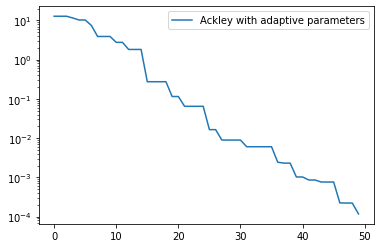

In [51]:
Ackley_sacpmde()

(array([ 2.38844150e-05, -2.85085827e-05]), 0.00010523016172214739)
0:00:00.360999


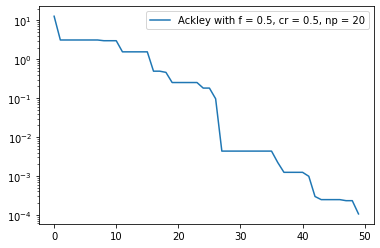

In [37]:
Ackley_de()

(array([ 9.51977957e-06, -1.53357072e-05]), 5.1062382359745584e-05)
0:00:00.341999


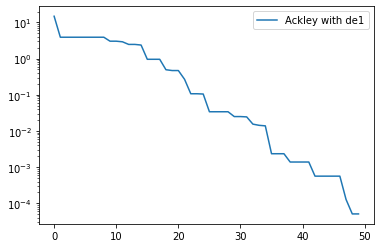

In [52]:
Ackley_de1()

(array([ 1.70829172e-05, -2.43621547e-05,  8.48561187e-06, -6.46922700e-06,
       -1.18024351e-05, -5.95992723e-06, -3.89134868e-06, -7.39711879e-06,
        1.65811491e-05,  5.02866071e-06,  2.44958930e-05, -1.78649866e-06,
       -3.01196456e-06, -7.28931667e-06,  1.72090451e-05, -2.72320774e-05,
        6.66198376e-06,  2.92264452e-05, -1.61238983e-05,  1.32131325e-06,
       -1.94548376e-05,  9.03681401e-06, -1.06848393e-05,  1.10141573e-05,
       -9.27310914e-06,  7.75387603e-06,  2.20325566e-06,  1.55801181e-05,
       -1.32668103e-05,  1.04491856e-05]), 1.1471243812621879e-06)
0:00:22.868157


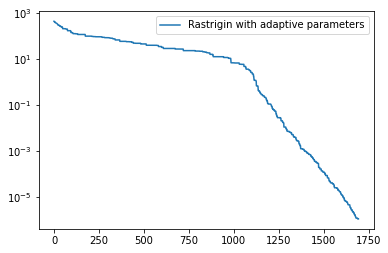

In [77]:
Rastrigin_sacpmde()

(array([ 0.12300591, -0.01370614, -1.13095728, -0.1844785 ,  2.16279107,
        0.61838666, -0.13264591,  0.11428411, -0.95285543,  0.20391629,
        1.87790703,  2.87317312,  1.06112319, -0.66790781, -0.16219547,
       -2.05936939,  2.95738069, -1.66954656, -0.97967979,  0.02801744,
        0.66582937,  0.88486028,  0.11154349, -1.08665932,  1.19339699,
        0.05440709,  0.84980096,  1.8466517 , -0.12992599, -0.13215696]), 178.68208875623685)
0:00:18.042000


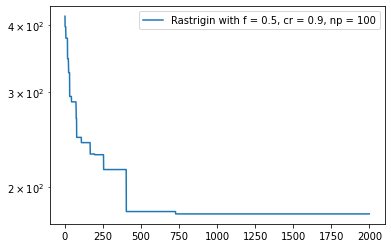

In [53]:
Rastrigin_de() #得不到结果

(array([ 0.54639692, -0.91289359,  0.03486582, -0.04363593,  0.03851752,
        0.87692324,  1.17625132, -0.32189632, -1.05515748, -1.16820096,
        1.05429599, -0.21666207,  0.01836708, -1.80684938, -0.77202068,
       -0.06471728,  1.0335089 ,  1.01698242, -0.13267931,  1.03282799,
        0.85559882,  0.88675111,  0.96223955,  0.94548978, -0.89061189,
        0.76279503,  0.96528526,  2.0193601 , -0.01507465,  1.05385611]), 123.06540200601495)
0:00:19.084998


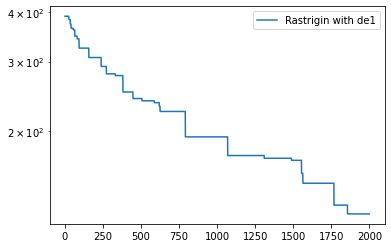

In [54]:
Rastrigin_de1() #得不到结果

c:\users\oliver\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


(array([-0.00119488, -0.00065493]), -0.9999981414704416)
0:00:00.724029


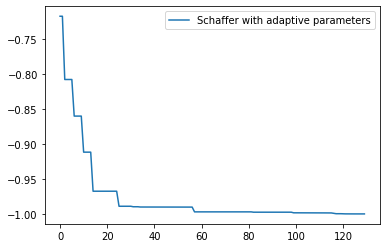

In [78]:
Schaffer_sacpmde()

(array([-0.00575867, -0.01074389]), -0.9998512653381111)
0:00:00.777997


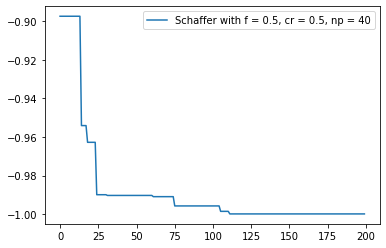

In [72]:
Schaffer_de()

(array([0.006103  , 0.03064853]), -0.9990227642060057)
0:00:00.770998


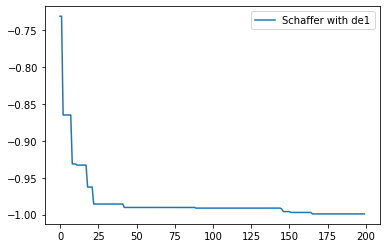

In [55]:
Schaffer_de1()

(array([ 2.08812825e-04, -1.15925180e-03,  3.79808044e-04,  8.73599692e-05,
       -1.85592469e-04,  5.96095720e-04, -7.50198188e-05,  2.76858626e-04,
        1.84052435e-05,  1.76025623e-04, -2.95807075e-04,  1.35956539e-03,
        1.10154920e-03,  4.71555292e-05, -1.45753678e-03,  9.75267882e-04,
        5.72228564e-04, -6.02852716e-04,  2.79418868e-04, -3.72716965e-04,
       -8.20204352e-04,  1.18426506e-03, -9.69184898e-04, -1.04530997e-03,
        1.77755211e-03,  3.19757308e-04,  1.95897001e-03, -2.14844544e-03,
        1.98102430e-03,  8.97166363e-05]), 1.055891341567889e-06)
0:00:17.558030


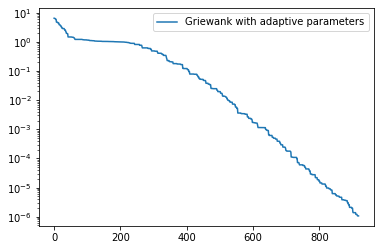

In [27]:
Griewank_sacpmde()

(array([ 9.84348178e-05,  4.66076746e-04,  5.30953685e-04,  6.50062703e-04,
       -3.61795541e-04,  4.07351745e-04,  1.96766129e-04, -7.47649702e-04,
        2.63633219e-04, -2.32772546e-04,  2.33947612e-05, -2.52747345e-06,
       -1.02721604e-03, -9.33290969e-04,  2.57149441e-03,  1.89191981e-03,
        6.89894807e-04, -7.30976129e-04,  1.93577375e-03, -1.01687439e-03,
        6.66699882e-04, -1.23606070e-03, -6.83905548e-04, -1.00886719e-03,
       -4.69215779e-04, -6.88693613e-04, -2.48207975e-03, -3.73406607e-04,
        3.88124022e-04, -1.73137489e-04]), 1.0049442675353518e-06)
0:00:11.009173


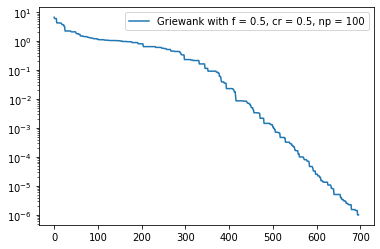

In [26]:
Griewank_de()

(array([-1.87593858e-04, -2.94957639e-04, -1.12855197e-04, -9.99001313e-04,
       -9.33256696e-04,  7.56338975e-04, -4.99108192e-04, -7.40663279e-04,
       -9.42560864e-05, -1.09901038e-03,  3.25776058e-05,  3.10906780e-04,
        7.76309734e-04, -5.60741848e-04, -7.53480657e-05, -1.15951108e-03,
        1.36780842e-03,  6.22183408e-04, -2.11216683e-03,  7.20560151e-04,
       -3.66027613e-04,  1.74650275e-04, -1.21388752e-03, -2.21033673e-03,
       -2.30037385e-03, -5.09536565e-04,  2.04092958e-03,  8.91605415e-04,
        1.45765648e-04,  2.04114952e-04]), 1.0395430062668119e-06)
0:00:14.532970


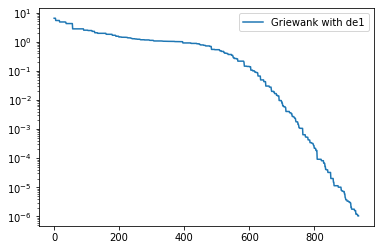

In [57]:
Griewank_de1()

### 线性变化参数，设置cr

In [61]:
# mut = (0.9 - 0.4)*(its - i)/ its + 0.4 
# crossp = 0.3 + (0.9 - 0.3) * (i / its)
# mut = (0.9 - 0.4) * (its ** 2 - i ** 2) ** 0.5 / its + 0.4
# crossp = 0.3 + (0.9 - 0.3) * (i ** 2 / its ** 2)